In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [55]:

# Load the dataset
data = pd.read_csv('train.csv') 

# Convert 'Date' column to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

# group by month
data['Order Date'] = data['Order Date'].dt.to_period('M')
preprocessed_data = data.groupby(['Order Date', 'Category'], as_index=False)['Sales'].sum()
preprocessed_data['Order Date'] = preprocessed_data['Order Date'].dt.to_timestamp()
preprocessed_data = preprocessed_data[['Order Date', 'Category', 'Sales']]


# group by day
#preprocessed_data = data.groupby(['Order Date', 'Category'], as_index=False)['Sales'].sum()

#preprocessed_data = preprocessed_data[['Order Date', 'Category', 'Sales']]

# Display preprocessed data
print(preprocessed_data.head())

# List of unique categories



  Order Date         Category     Sales
0 2015-01-01        Furniture  6217.277
1 2015-01-01  Office Supplies  4845.140
2 2015-01-01       Technology  3143.290
3 2015-02-01        Furniture  1839.658
4 2015-02-01  Office Supplies  1071.724


In [56]:
def moving_average(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    forecast_values = category_data['Sales'].rolling(window=6).mean()
    additional_months = pd.date_range(start='2019-01-01', periods=6, freq='MS')

    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Moving Average ('{category}')")
    #plt.plot(additional_months, forecast_values.tail(6), label=f"Moving Average Future Values ('{category}')", color='red')

    plt.legend()
    plt.title(f'Moving Average Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
    category_data['Sales']
    mse = mean_squared_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mae = mean_absolute_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mape = mean_absolute_percentage_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    r2 = r2_score(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])

    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

def exponential_smoothing(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    forecast_values = SimpleExpSmoothing(category_data['Sales']).fit(
        smoothing_level=0.2, optimized=False).fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Exponential Smoothing ('{category}')", color = "red")
    plt.legend()
    plt.title(f'Exponential Smoothing Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    r2 = r2_score(category_data['Sales'], forecast_values)

    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

def linear_regression(category):
    
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    additional_months = pd.date_range(start='2019-01-01', periods=6, freq='MS').astype('int64').values.reshape(-1, 1)

    X = category_data['Order Date'].astype('int64').values.reshape(-1, 1)  # Using Order Date as the predictor
    y = category_data['Sales']
    
    model = LinearRegression().fit(X, y)
    forecast_values = model.predict(X)
    
    #future_values = model.predict(additional_months)
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Linear Regression ('{category}')", color='yellow')
    plt.plot()
    plt.legend()
    plt.title(f'Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    r2 = r2_score(category_data['Sales'], forecast_values)


    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

def deseasonalized_linear_regression(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    
    # Group data by month and calculate the mean for each month
    category_data['Order Month'] = category_data['Order Date'].dt.month
    monthly_means = category_data.groupby('Order Month')['Sales'].mean()
    
    # Repeat the monthly mean to match the length of the dataset
    full_seasonal_pattern = category_data['Order Month'].map(monthly_means)
    
    # Deseasonalize the data
    deseasonalized = category_data['Sales'] / full_seasonal_pattern
    
    # Fit linear regression to the deseasonalized data
    X = category_data['Order Date'].astype('int64').values.reshape(-1, 1)  # Using Order Date as the predictor
    model = LinearRegression().fit(X, deseasonalized)
    deseasonalized_forecast_values = model.predict(X) * full_seasonal_pattern
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], deseasonalized_forecast_values, label=f"Deseasonalized Linear Regression ('{category}')", color='green')
    plt.legend()
    plt.title(f'Deseasonalized Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], deseasonalized_forecast_values)
    mae = mean_absolute_error(category_data['Sales'], deseasonalized_forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], deseasonalized_forecast_values)
    r2 = r2_score(category_data['Sales'], deseasonalized_forecast_values)

    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

def holts_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Holt's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add').fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Holt's Method ('{category}')", color='orange')
    plt.legend()
    plt.title(f"Holt's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    r2 = r2_score(category_data['Sales'], forecast_values)

    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

def winters_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Winter's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Winter's Method ('{category}')", color='green')
    plt.legend()
    plt.title(f"Winter's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    r2 = r2_score(category_data['Sales'], forecast_values)

    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}, R2: {r2}")
    return mse, mae, mape, r2

Category: Furniture


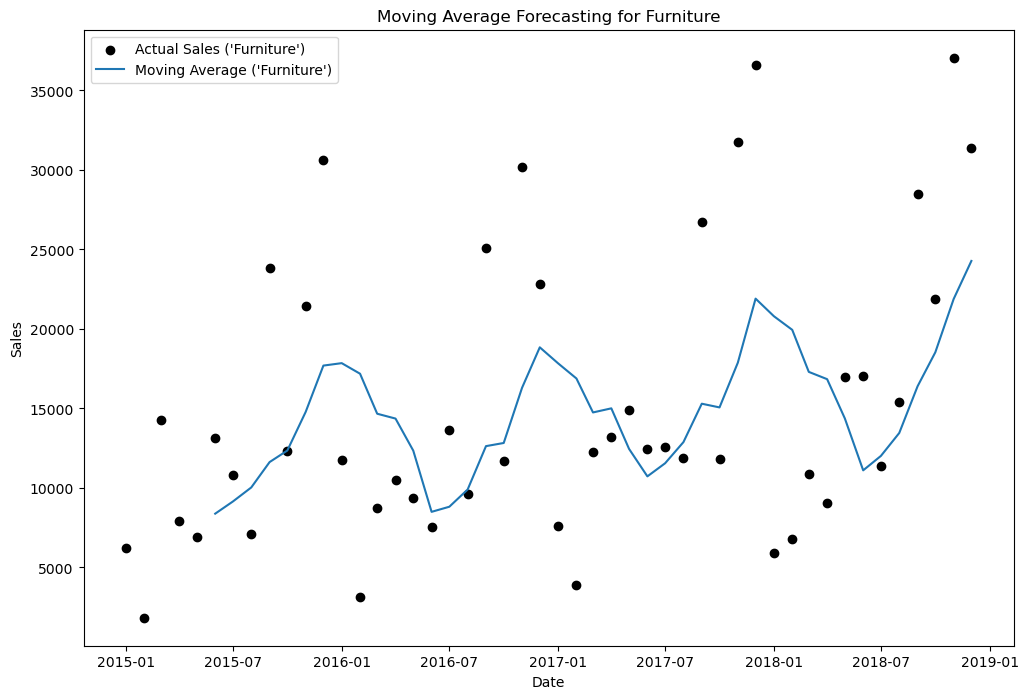

MSE: 67528697.5010548, MAE: 6505.763734883721, MAPE: 0.5829836593113049, R2: 0.15919358060626077


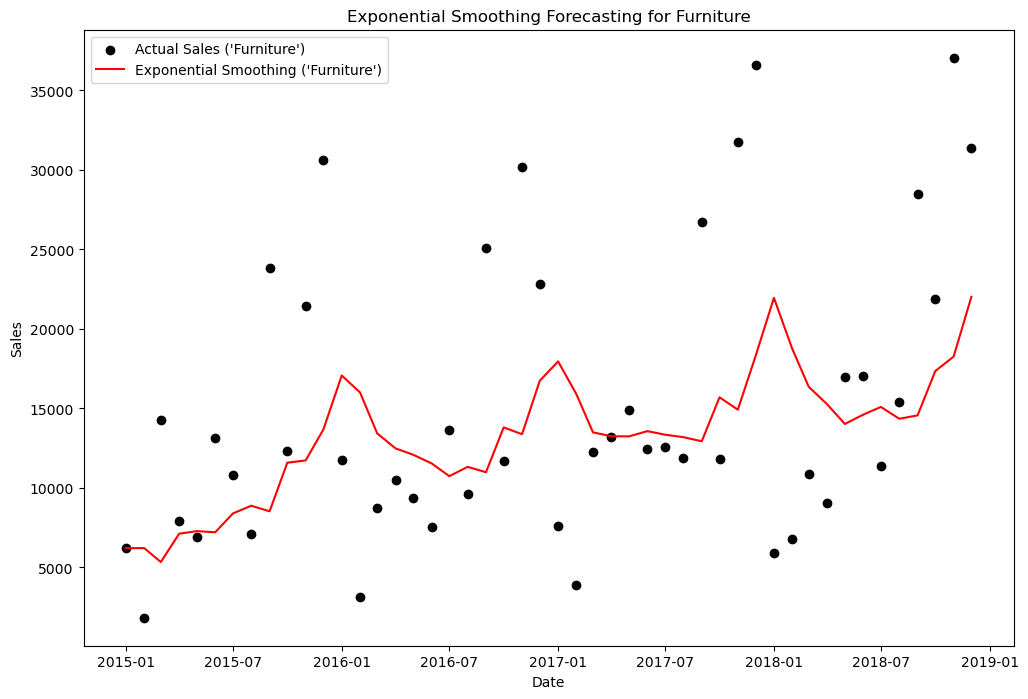

MSE: 78662860.59832689, MAE: 6675.2239890187075, MAPE: 0.5934252638869507, R2: 0.02391207243449711


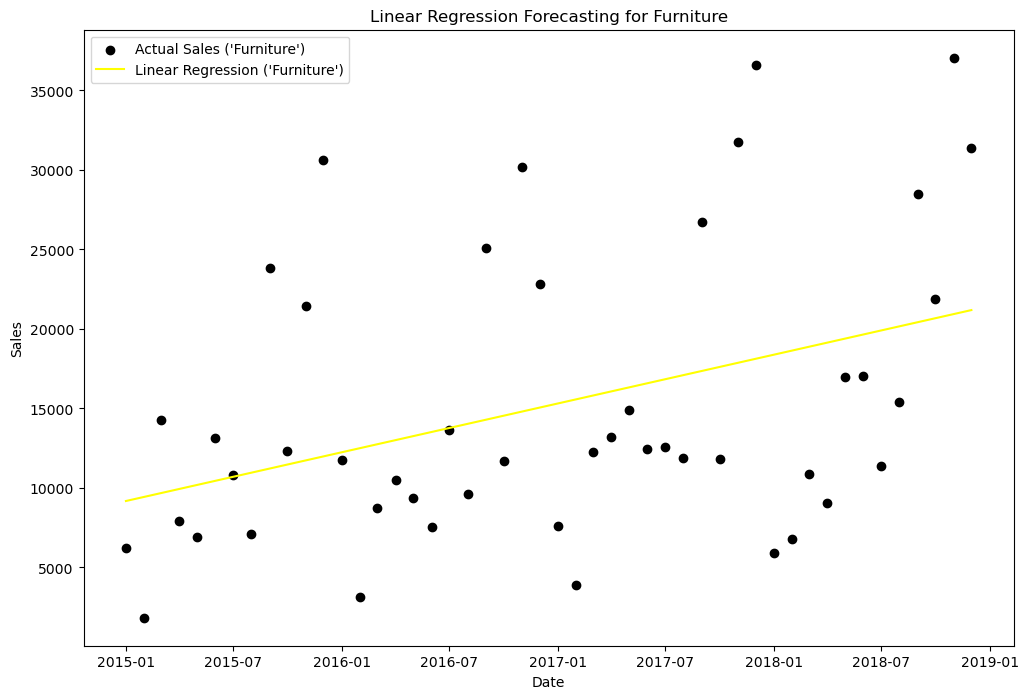

MSE: 68050875.80415158, MAE: 6691.401308805119, MAPE: 0.6379001626583306, R2: 0.15559086171721903


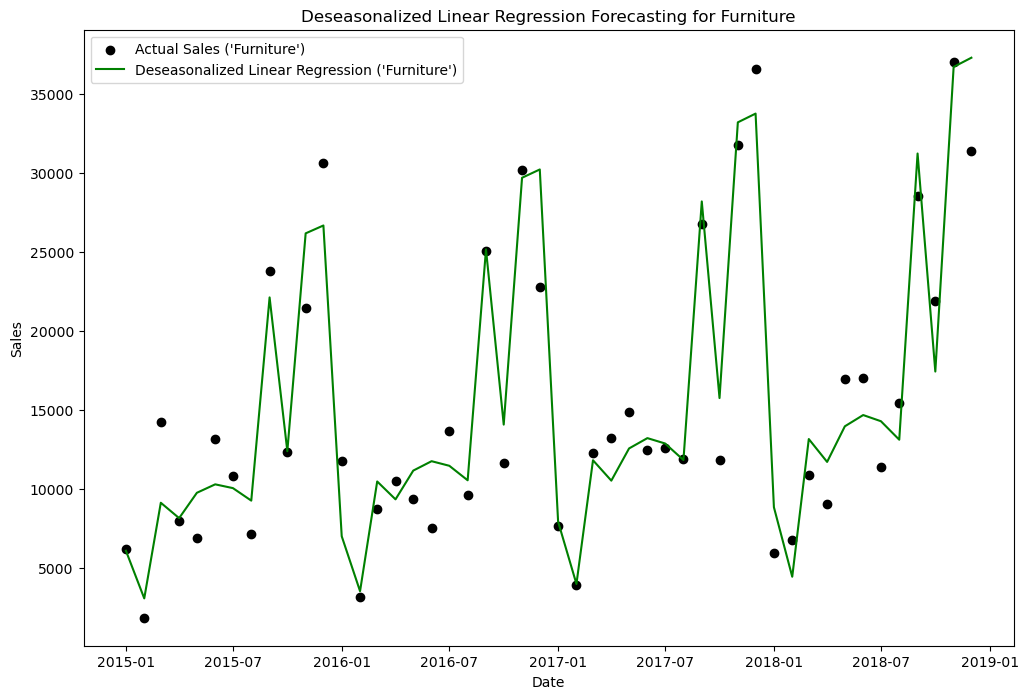

MSE: 7544820.443195959, MAE: 2166.3818247624586, MAPE: 0.17684896528576863, R2: 0.9063801126193773


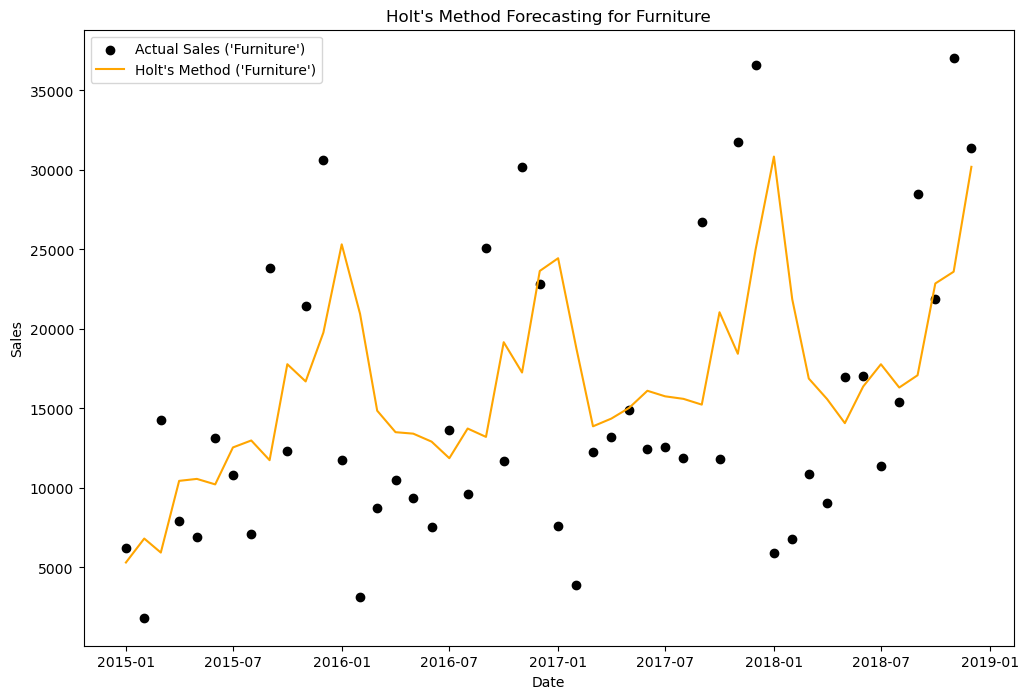

MSE: 79631089.76824026, MAE: 6964.436691787157, MAPE: 0.7608674902171862, R2: 0.011897802972634763


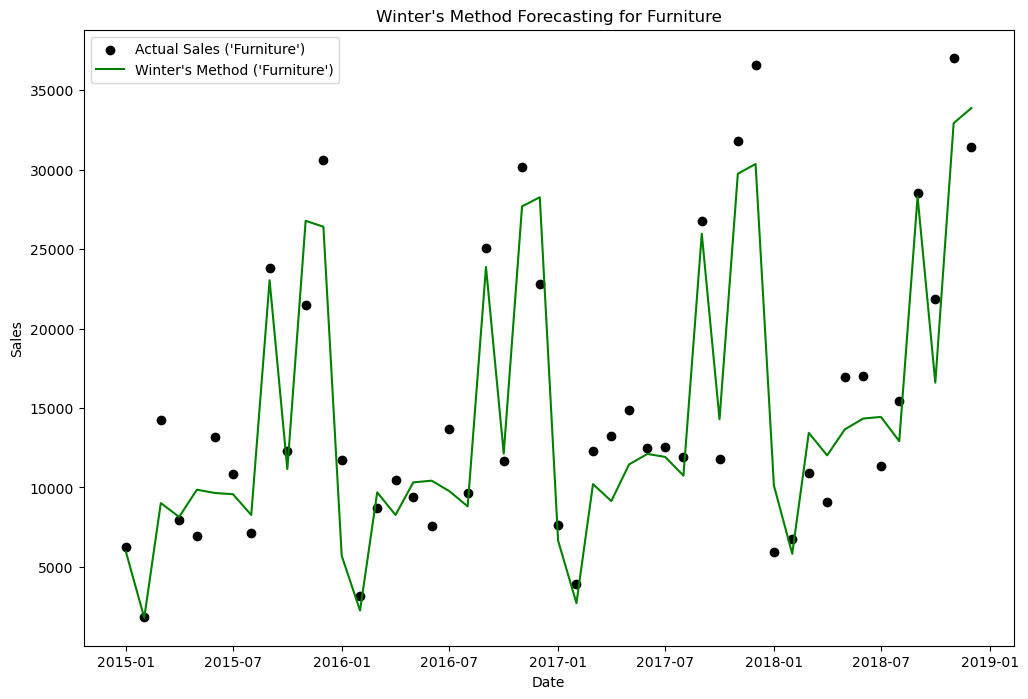

MSE: 8557841.826425934, MAE: 2377.608186594351, MAPE: 0.18232564445628974, R2: 0.8938100390800289
Category: Office Supplies


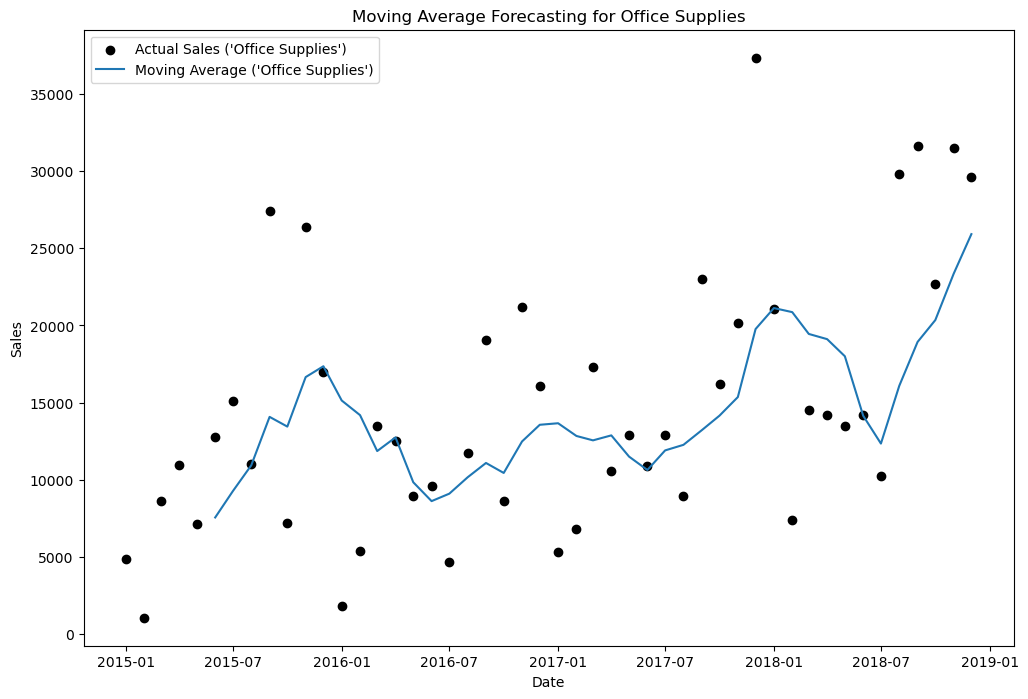

MSE: 48181992.70370333, MAE: 5256.2188720930235, MAPE: 0.5435738480168139, R2: 0.2866815554691471


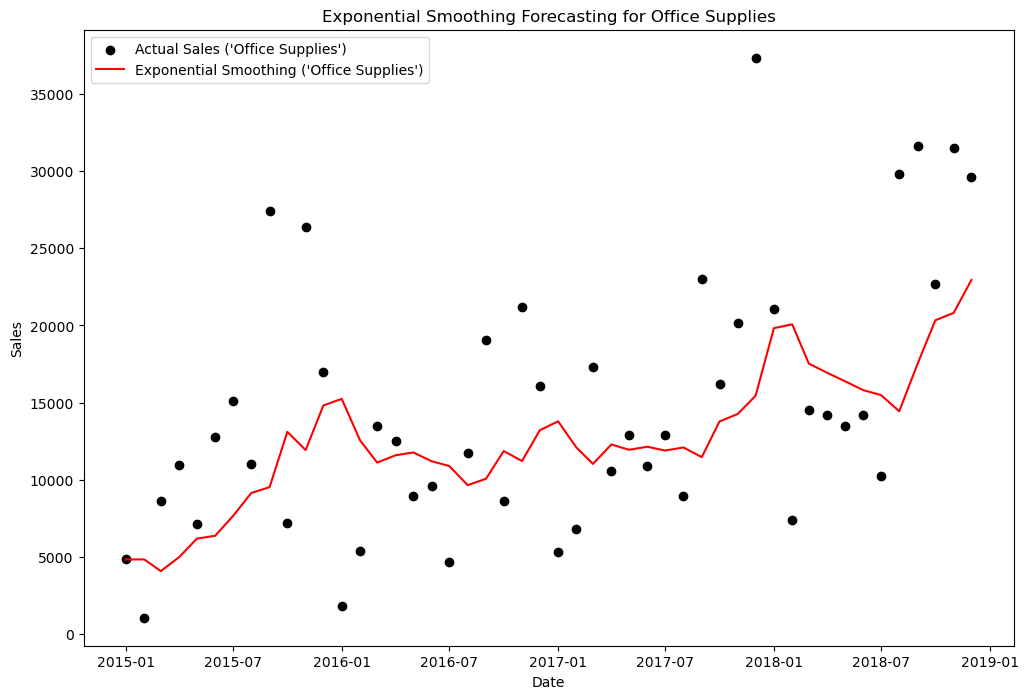

MSE: 59463087.18553704, MAE: 5863.109153275844, MAPE: 0.629484749492424, R2: 0.143917954294292


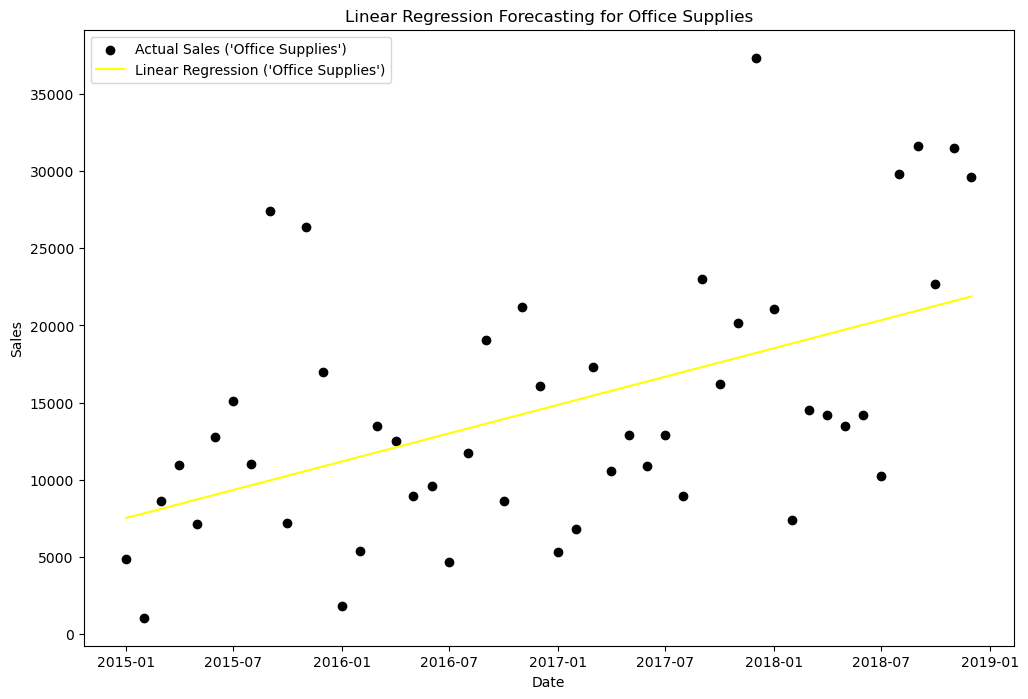

MSE: 51547926.45290639, MAE: 5817.456846743709, MAPE: 0.6797074237250204, R2: 0.2578714557486874


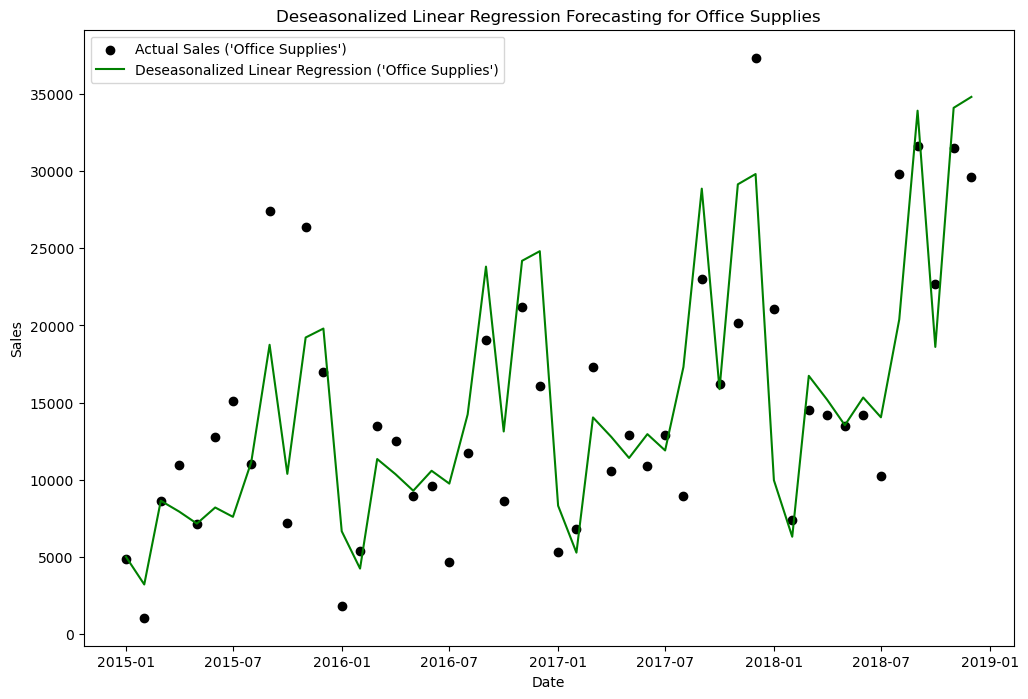

MSE: 20748900.49799222, MAE: 3522.4790216809392, MAPE: 0.3353050937012365, R2: 0.7012808781851183


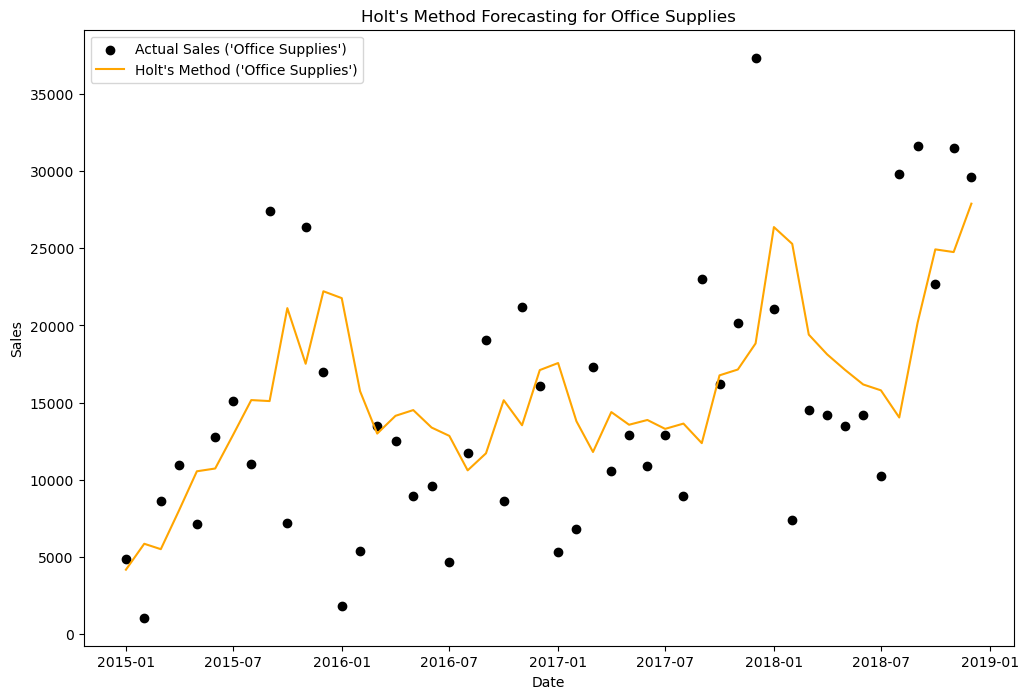

MSE: 60745189.26460847, MAE: 6001.919207385409, MAPE: 0.8017334311821895, R2: 0.12545970359448688


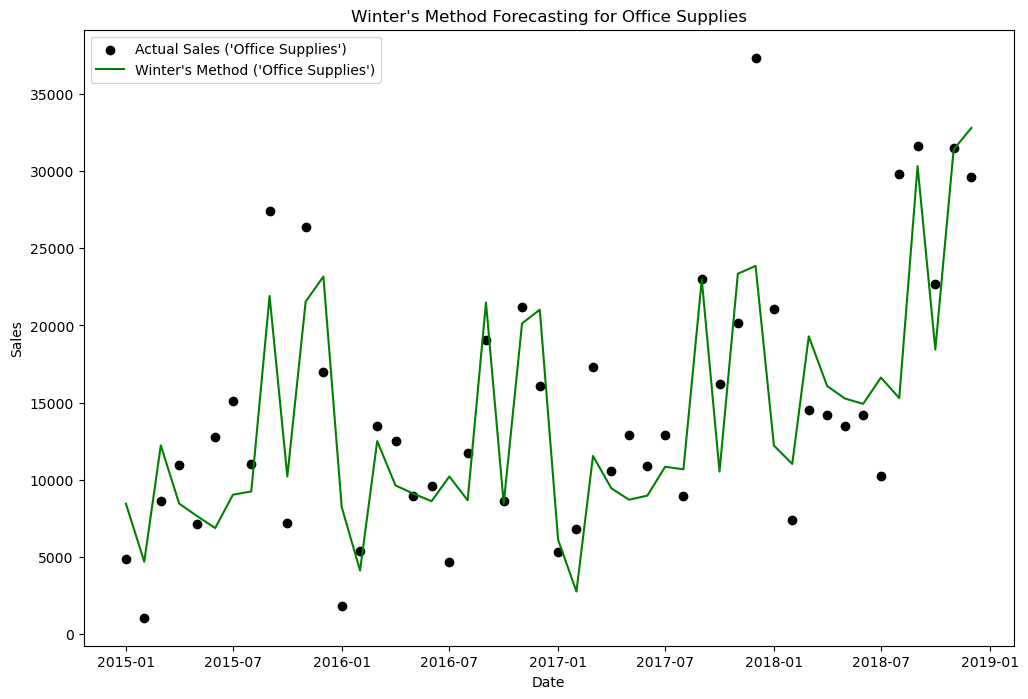

MSE: 21931842.151949264, MAE: 3592.259252331866, MAPE: 0.39816997143175614, R2: 0.6842502267507213
Category: Technology


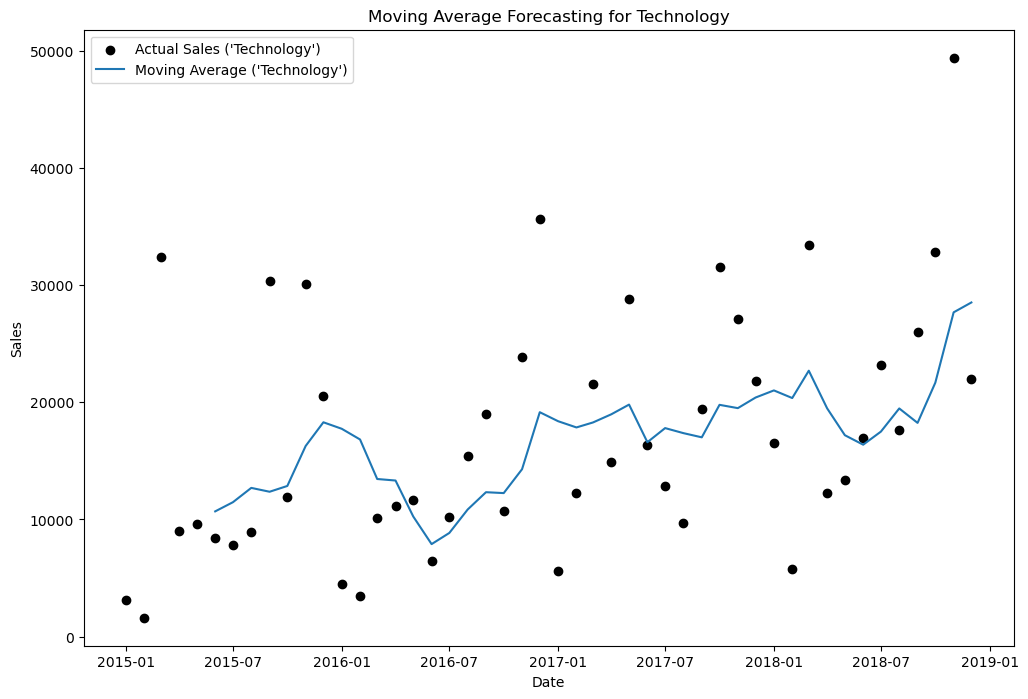

MSE: 72198619.0284371, MAE: 6673.084515503874, MAPE: 0.5375806651127444, R2: 0.26602552508798594


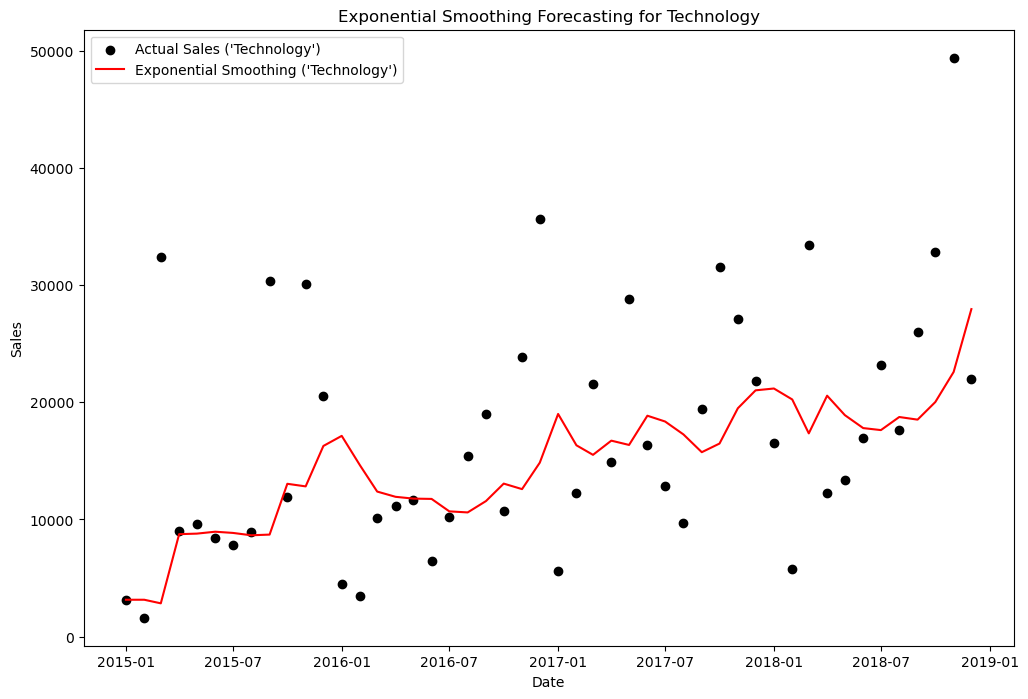

MSE: 104353567.60248888, MAE: 7249.671330559605, MAPE: 0.5224482282677031, R2: 0.008069013369022437


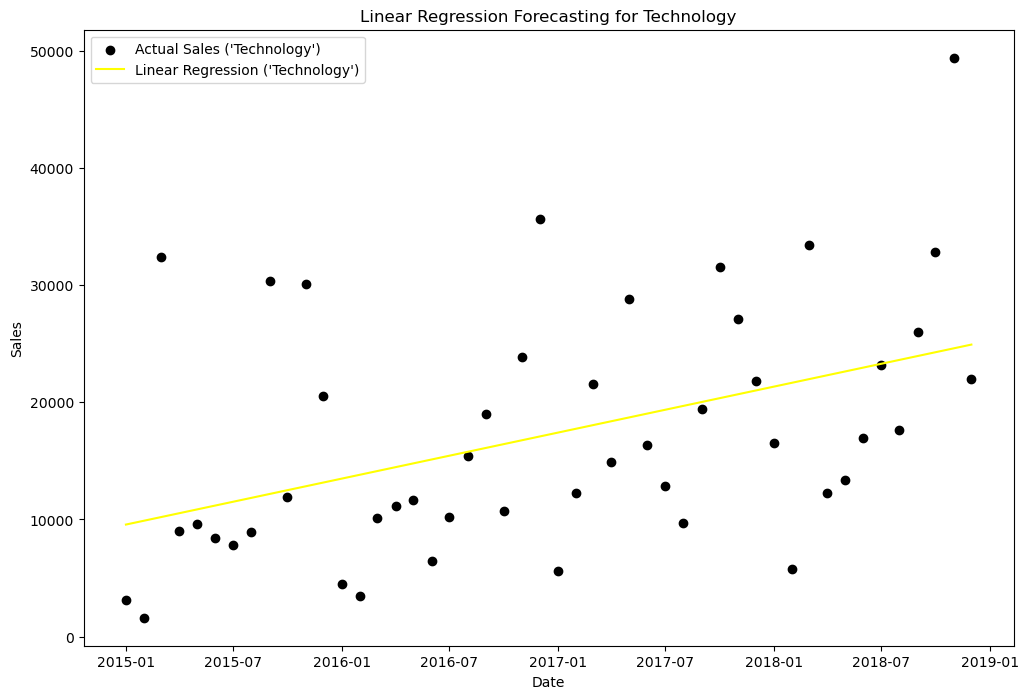

MSE: 84675142.06367578, MAE: 7194.489526184568, MAPE: 0.6760375506778273, R2: 0.19512193842487402


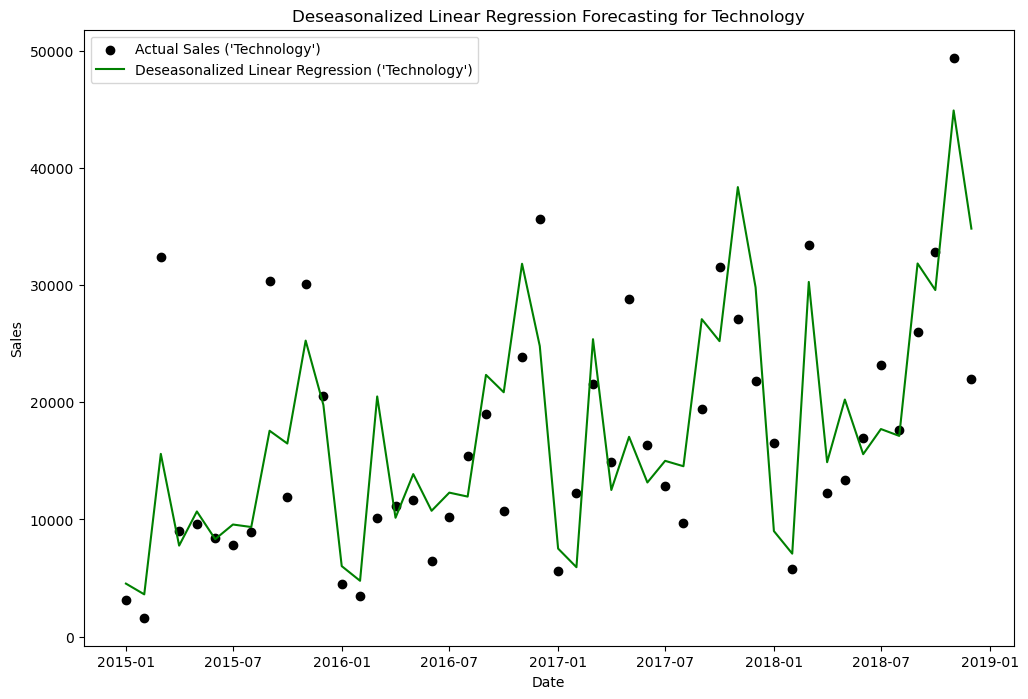

MSE: 38790283.10755523, MAE: 4813.4944191834475, MAPE: 0.31838649116954315, R2: 0.6312796516824164


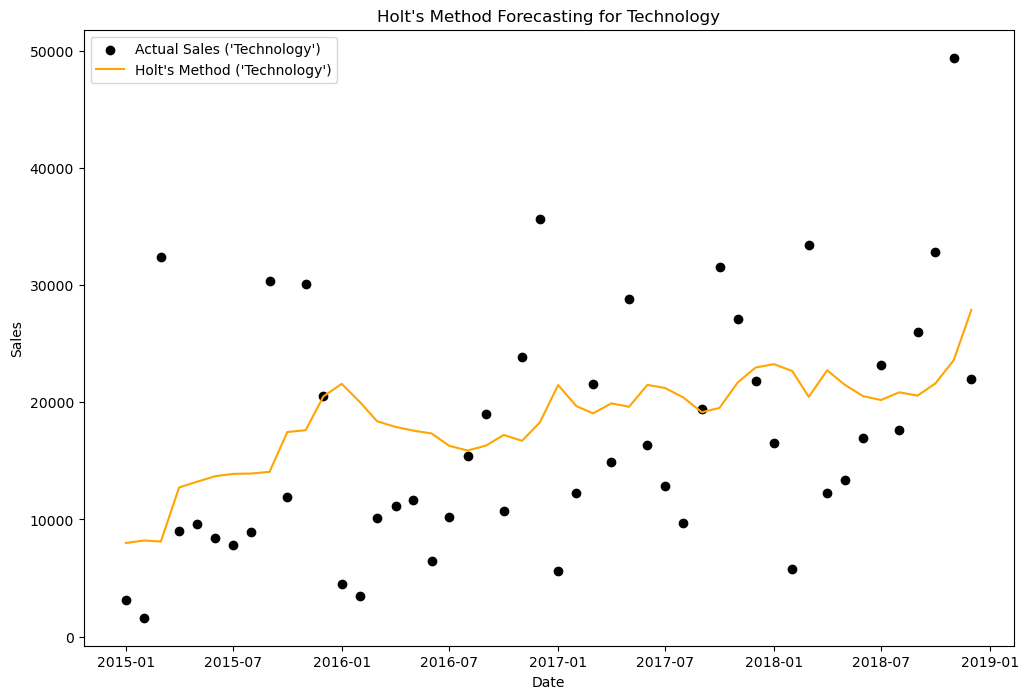

MSE: 101446066.64001887, MAE: 8248.758222536087, MAPE: 0.8099744839202865, R2: 0.035706212217072264


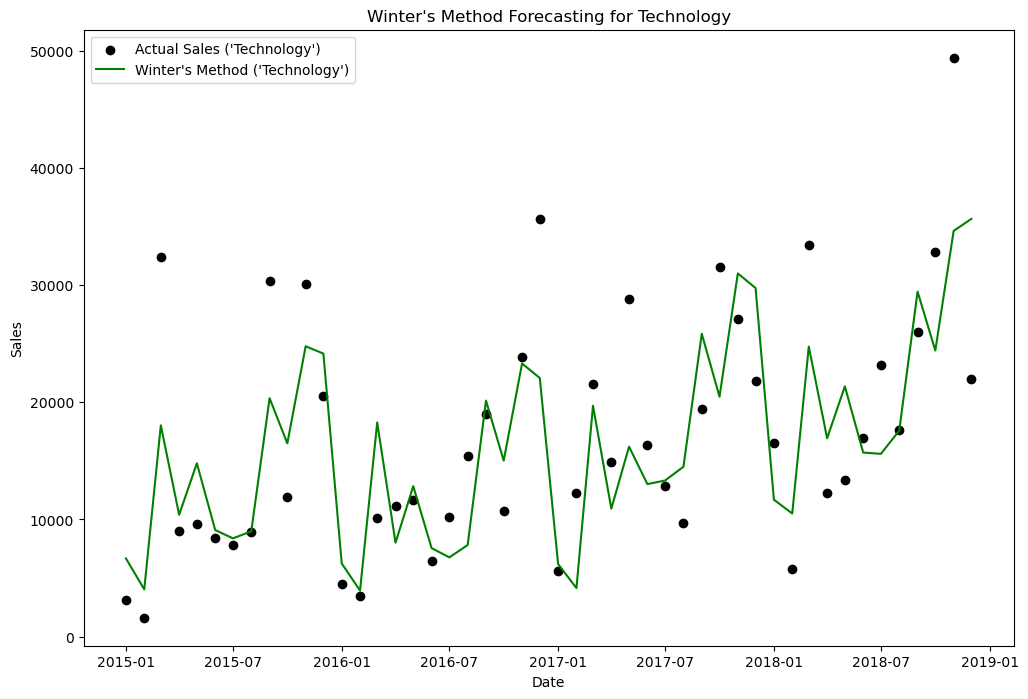

MSE: 42655431.47704601, MAE: 5067.1563747947575, MAPE: 0.33555057843821673, R2: 0.5945395523862553


,Category,Method,MSE,MAE,MAPE,R2
3,Furniture,Deseasonalized Linear Regression,7.544820e+06,2166.381825,0.176849,0.906380
5,Furniture,Winter's Method,8.557842e+06,2377.608187,0.182326,0.893810
9,Office Supplies,Deseasonalized Linear Regression,2.074890e+07,3522.479022,0.335305,0.701281
11,Office Supplies,Winter's Method,2.193184e+07,3592.259252,0.398170,0.684250
15,Technology,Deseasonalized Linear Regression,3.879028e+07,4813.494419,0.318386,0.631280
17,Technology,Winter's Method,4.265543e+07,5067.156375,0.335551,0.594540
6,Office Supplies,Moving Average,4.818199e+07,5256.218872,0.543574,0.286682
12,Technology,Moving Average,7.219862e+07,6673.084516,0.537581,0.266026
8,Office Supplies,Linear Regression,5.154793e+07,5817.456847,0.679707,0.257871
14,Technology,Linear Regression,8.467514e+07,7194.489526,0.676038,0.195122


In [58]:
categories = preprocessed_data['Category'].unique()
methods = {
    'Moving Average': moving_average,
    'Exponential Smoothing': exponential_smoothing,
    'Linear Regression': linear_regression,
    'Deseasonalized Linear Regression': deseasonalized_linear_regression,
    "Holt's Method": holts_method,
    "Winter's Method": winters_method
}

performance_metrics = []

for category in categories:
    print(f'Category: {category}')
    for method_name, method_func in methods.items():
        mse, mae, mape, r2 = method_func(category)
        performance_metrics.append({
            'Category': category,
            'Method': method_name,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        })

performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics.sort_values(by='R2', axis=0, ascending=False, inplace=True)
performance_metrics
